In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import concat
%matplotlib inline

In [2]:
from pandas import read_csv
from datetime import datetime
# load data
dataset = read_csv('da01_min.csv')

In [3]:
print(dataset.head(5))

    ����ʱ��  �й�������Сֵ��kw��  ��  ��.1  һ��ڼ���  һ��ڼ���.1  weekday  ����  \
0  2019/1/1         51526.5690   1     1        1          1        1     1   
1  2019/1/2         63638.4294   1     2        2          1        2     1   
2  2019/1/3        102048.2754   1     3        3          1        3     1   
3  2019/1/4        104466.0762   1     4        4          1        4     1   
4  2019/1/5         99507.3528   1     5        5          1        5     1   

   �Ƿ��³�  �Ƿ���ĩ  �Ƿ񼾽ڳ�  �Ƿ񼾽�ĩ  �Ƿ���ĩ.1  ����״��  ����¶�  ����¶�.1  \
0       1       0      1      0         0      3.0    12.0       7.0   
1       0       0      0      0         0      5.0    11.0       6.0   
2       0       0      0      0         0      2.0    15.0       9.0   
3       0       0      0      0         0      3.0    17.0      12.0   
4       0       0      0      0         1      3.0    17.0      12.0   

   �����������  ҹ����������  
0         11.0          8.0  
1         11.0          8.0  
2 

In [4]:
# manually specify column names
#dataset.drop('Unnamed: 0 ', axis=1, inplace=True)

In [5]:
print(dataset.head(5))

    ����ʱ��  �й�������Сֵ��kw��  ��  ��.1  һ��ڼ���  һ��ڼ���.1  weekday  ����  \
0  2019/1/1         51526.5690   1     1        1          1        1     1   
1  2019/1/2         63638.4294   1     2        2          1        2     1   
2  2019/1/3        102048.2754   1     3        3          1        3     1   
3  2019/1/4        104466.0762   1     4        4          1        4     1   
4  2019/1/5         99507.3528   1     5        5          1        5     1   

   �Ƿ��³�  �Ƿ���ĩ  �Ƿ񼾽ڳ�  �Ƿ񼾽�ĩ  �Ƿ���ĩ.1  ����״��  ����¶�  ����¶�.1  \
0       1       0      1      0         0      3.0    12.0       7.0   
1       0       0      0      0         0      5.0    11.0       6.0   
2       0       0      0      0         0      2.0    15.0       9.0   
3       0       0      0      0         0      3.0    17.0      12.0   
4       0       0      0      0         1      3.0    17.0      12.0   

   �����������  ҹ����������  
0         11.0          8.0  
1         11.0          8.0  
2 

In [6]:
dataset.columns = ['数据时间','有功功率最大值（kw）','月','天','一年第几天','一年第几周','weekday','季节','是否月初','是否月末','是否季节初','是否季节末','是否周末','天气状况','最高温度','最低温度','白天风力风向','夜晚风力风向']

In [7]:
dataset.drop('数据时间', axis=1, inplace=True)
# summarize first 5 rows
#print(dataset.head(5))
# save to file
dataset.to_csv('power.csv')

In [8]:
print(dataset)

       有功功率最大值（kw）   月   天  一年第几天  一年第几周  weekday  季节  是否月初  是否月末  是否季节初  \
0      51526.56900   1   1      1      1        1   1     1     0      1   
1      63638.42940   1   2      2      1        2   1     0     0      0   
2     102048.27540   1   3      3      1        3   1     0     0      0   
3     104466.07620   1   4      4      1        4   1     0     0      0   
4      99507.35280   1   5      5      1        5   1     0     0      0   
...            ...  ..  ..    ...    ...      ...  ..   ...   ...    ...   
1060   94921.31352  11  26    330     47        4   4     0     0      0   
1061   95399.21256  11  27    331     47        5   4     0     0      0   
1062   94366.49616  11  28    332     47        6   4     0     0      0   
1063   89774.21316  11  29    333     48        0   4     0     0      0   
1064   90599.10912  11  30    334     48        1   4     0     1      0   

      是否季节末  是否周末  天气状况   最高温度   最低温度  白天风力风向  夜晚风力风向  
0         0     0  3.00  12.00 

In [9]:
# prepare data for lstm
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('power.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]], axis=1, inplace=True)
#print(reframed.head())
print(reframed.head)

<bound method NDFrame.head of       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      0.441537   0.000000   0.000000   0.000000   0.000000   0.166667   
2      0.545331   0.000000   0.033333   0.002740   0.000000   0.333333   
3      0.874487   0.000000   0.066667   0.005479   0.000000   0.500000   
4      0.895206   0.000000   0.100000   0.008219   0.000000   0.666667   
5      0.852712   0.000000   0.133333   0.010959   0.000000   0.833333   
...         ...        ...        ...        ...        ...        ...   
1060   0.838598   0.909091   0.800000   0.898630   0.884615   0.500000   
1061   0.813412   0.909091   0.833333   0.901370   0.884615   0.666667   
1062   0.817507   0.909091   0.866667   0.904110   0.884615   0.833333   
1063   0.808657   0.909091   0.900000   0.906849   0.884615   1.000000   
1064   0.769303   0.909091   0.933333   0.909589   0.903846   0.000000   

      var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   

In [10]:
#plt.plot(reframed)
#plt.show()

In [11]:
...
# split into train and test sets
values = reframed.values
n_train_hours = int(len(reframed)-91)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(973, 1, 17) (973,) (91, 1, 17) (91,)


Epoch 1/100
14/14 - 1s - loss: 0.6013 - val_loss: 0.5549 - 1s/epoch - 98ms/step
Epoch 2/100
14/14 - 0s - loss: 0.3866 - val_loss: 0.2660 - 29ms/epoch - 2ms/step
Epoch 3/100
14/14 - 0s - loss: 0.2192 - val_loss: 0.1001 - 30ms/epoch - 2ms/step
Epoch 4/100
14/14 - 0s - loss: 0.1756 - val_loss: 0.1057 - 30ms/epoch - 2ms/step
Epoch 5/100
14/14 - 0s - loss: 0.1544 - val_loss: 0.0777 - 29ms/epoch - 2ms/step
Epoch 6/100
14/14 - 0s - loss: 0.1529 - val_loss: 0.0701 - 31ms/epoch - 2ms/step
Epoch 7/100
14/14 - 0s - loss: 0.1434 - val_loss: 0.0667 - 30ms/epoch - 2ms/step
Epoch 8/100
14/14 - 0s - loss: 0.1375 - val_loss: 0.0627 - 31ms/epoch - 2ms/step
Epoch 9/100
14/14 - 0s - loss: 0.1338 - val_loss: 0.0617 - 30ms/epoch - 2ms/step
Epoch 10/100
14/14 - 0s - loss: 0.1308 - val_loss: 0.0597 - 30ms/epoch - 2ms/step
Epoch 11/100
14/14 - 0s - loss: 0.1289 - val_loss: 0.0597 - 29ms/epoch - 2ms/step
Epoch 12/100
14/14 - 0s - loss: 0.1267 - val_loss: 0.0584 - 30ms/epoch - 2ms/step
Epoch 13/100
14/14 - 0s - 

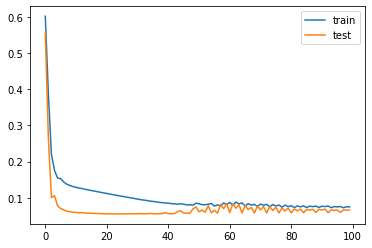

In [12]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
# make predictions
#trainPredict = model.predict(train_X)
#testPredict = model.predict(test_X)

In [14]:
...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [15]:
yhat=DataFrame(yhat)
test_X=DataFrame(test_X)
print(yhat.shape,test_X.shape)

(91, 1) (91, 17)


In [16]:
test_X[0]=yhat
test_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.655857,0.636364,1.000000,0.663014,0.653846,0.166667,0.666667,0.0,1.0,0.0,0.0,0.0,1.00000,0.785714,0.884615,0.875000,0.875000
1,0.863049,0.727273,0.000000,0.665753,0.653846,0.333333,0.666667,1.0,0.0,0.0,0.0,0.0,0.34375,0.864286,0.909615,0.525000,0.525000
2,0.791418,0.727273,0.033333,0.668493,0.653846,0.500000,0.666667,0.0,0.0,0.0,0.0,0.0,0.41250,0.857143,0.898077,0.525000,0.525000
3,0.922155,0.727273,0.066667,0.671233,0.653846,0.666667,0.666667,0.0,0.0,0.0,0.0,0.0,0.34375,0.867857,0.905769,0.525000,0.525000
4,0.930974,0.727273,0.100000,0.673973,0.653846,0.833333,0.666667,0.0,0.0,0.0,0.0,1.0,0.23125,0.860714,0.898077,0.587500,0.587500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.855582,0.909091,0.800000,0.898630,0.884615,0.500000,1.000000,0.0,0.0,0.0,0.0,0.0,0.11250,0.594643,0.569231,0.634375,0.634375
87,0.838056,0.909091,0.833333,0.901370,0.884615,0.666667,1.000000,0.0,0.0,0.0,0.0,0.0,0.12500,0.564286,0.513462,0.262500,0.262500
88,0.844167,0.909091,0.866667,0.904110,0.884615,0.833333,1.000000,0.0,0.0,0.0,0.0,1.0,0.12500,0.487500,0.473077,0.525000,0.525000
89,0.828404,0.909091,0.900000,0.906849,0.884615,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.01875,0.407143,0.403846,0.634375,0.634375


In [17]:
inv_yhat = scaler.inverse_transform(test_X)
inv_yhat = inv_yhat[:,0]

In [18]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X[0]=test_y
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]

In [19]:
# calculate RMSE
from math import sqrt
#trainScore = sqrt(mean_squared_error(train_y[0], inv_yhat[0]))
#print('Train Score: %.3f RMSE' % (trainScore))
rmse2 = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.3f' % rmse2)

Test Score: 13856.568


In [20]:
inv_y

array([ 96178.54 ,  85958.28 , 104856.62 , 105046.13 , 101946.05 ,
        99299.15 , 104747.03 ,  42587.543, 108876.43 , 107506.2  ,
       107083.17 ,  98535.14 ,  76972.98 ,  84183.77 ,  97322.414,
       105006.95 , 105600.164, 105199.625, 102586.766,  98552.734,
       106463.72 , 104703.51 , 105195.445, 105720.05 , 104552.33 ,
       103317.14 , 102804.67 , 104933.26 , 103046.4  ,  80239.24 ,
        45351.934,  48176.355,  59212.508,  81838.49 ,  92019.195,
        94909.555,  96903.43 , 101195.13 , 100791.27 , 103012.484,
        96879.586, 103118.3  , 100882.8  , 104856.66 ,  97584.05 ,
        99830.59 ,  93172.42 ,  94776.95 , 100252.664,  96747.73 ,
       101210.93 , 103190.87 ,  99130.09 , 101264.086,  92155.09 ,
        90497.164,  96948.734,  98630.21 , 101191.78 ,  93853.36 ,
        95504.44 ,  90021.26 ,  93596.08 ,  95920.49 , 100159.25 ,
       101408.71 ,  99984.26 ,  99919.68 ,  94172.805,  68525.95 ,
        97391.64 ,  96375.36 ,  97751.64 , 101655.055,  98628.

In [21]:
print(len(inv_y),len(inv_yhat))

91 91


In [22]:
inv_yhat

array([ 76535.97 , 100713.62 ,  92354.83 , 107610.71 , 108639.836,
       106926.12 , 104836.75 , 108833.516,  58042.605, 111466.89 ,
       109941.54 , 110845.16 , 103243.125,  86277.02 ,  91554.53 ,
       101920.74 , 107782.125, 107806.36 , 109017.64 , 107246.91 ,
       103867.27 , 109806.02 , 107682.03 , 107626.66 , 107229.914,
       107021.97 , 106573.016, 106726.08 , 108219.82 , 105926.3  ,
        79437.836,  54042.945,  61968.145,  70255.79 ,  89813.74 ,
        97813.3  ,  98969.49 , 100032.836, 103628.49 , 103888.68 ,
       106246.805, 101337.06 , 105980.3  , 104361.93 , 107358.58 ,
       100121.445, 103901.72 ,  97248.4  ,  99387.76 , 104030.37 ,
        99838.305, 103584.86 , 104928.516, 102871.41 , 103869.305,
        96170.58 ,  95014.1  ,  99401.34 ,  99971.63 , 102408.766,
        96255.29 ,  95818.87 ,  95074.4  ,  99181.43 ,  99886.19 ,
       102981.734, 103317.164, 104647.19 , 104411.875,  99248.09 ,
        78957.89 , 100911.58 ,  99357.71 , 100659.086, 105608.

In [23]:
import numpy as np
from sklearn import metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))
print('MAPE:',mape(inv_y, inv_yhat))

MAPE: 0.104413085


In [24]:
from sklearn.metrics import r2_score
print('R2-score:',r2_score(inv_y, inv_yhat))

R2-score: -0.013825202264190928


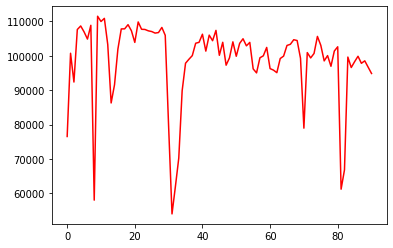

In [25]:
plt.plot(inv_yhat,'r')

In [26]:
import pandas as pd
inv_yhat=pd.DataFrame(data=inv_yhat)
inv_yhat.to_csv('inv_y.csv')
inv_yhat.to_csv('da01min_pre.csv')